In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros
# passa faixa sobre a frequência de interesse (2hz pra baixo e 2hz pra cima)

# filtro em que você deseja extrair frequências em uma faixa específica de interesse
def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

# filtro usado quando você deseja remover componentes de alta frequência do sinal
def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)

# filtro usado para remover componentes de baixa frequência do sinal
def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)

# filtro para remover interferências de frequência, como ruído elétrico de 50 ou 60 Hz em dados EEG.
def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)
    

In [2]:
# psd é pegar todos os dados transformados no domínio do tempo e frequência, deixando mais evidente as informações com a amplitude (potência mais alta)
# quando coloca no domínio da frequência vem a parte imaginária, por isso faz módulo. psd consegue mostrar a parte imaginária. serve para a classificação
# cores -> energia do sinal

# cada tentativa está em um dado diferente no multitarget
# vai ter 20 amostras
#8192 x 20
def print_graphs(data):
    for i in range(0, 10, 1):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 10, 1):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 10, 1):
        plt.specgram(data[i,:], Fs=512)
        plt.title('Espectograma')
    plt.show()

In [3]:
data = np.load("../datasets/avi/multi/data_sub6.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.T
data.shape

(8192, 10)


(10, 8192)

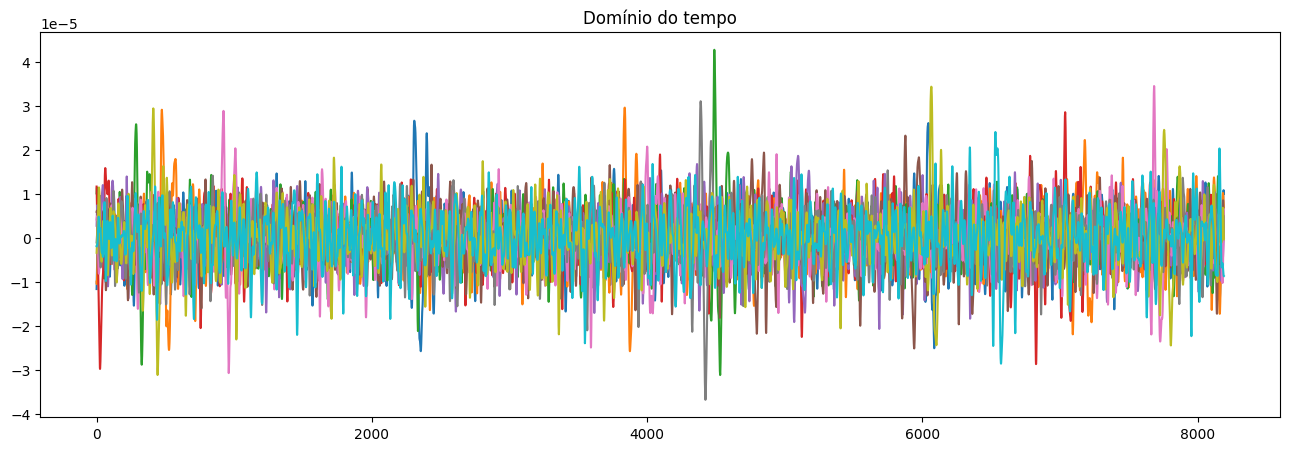

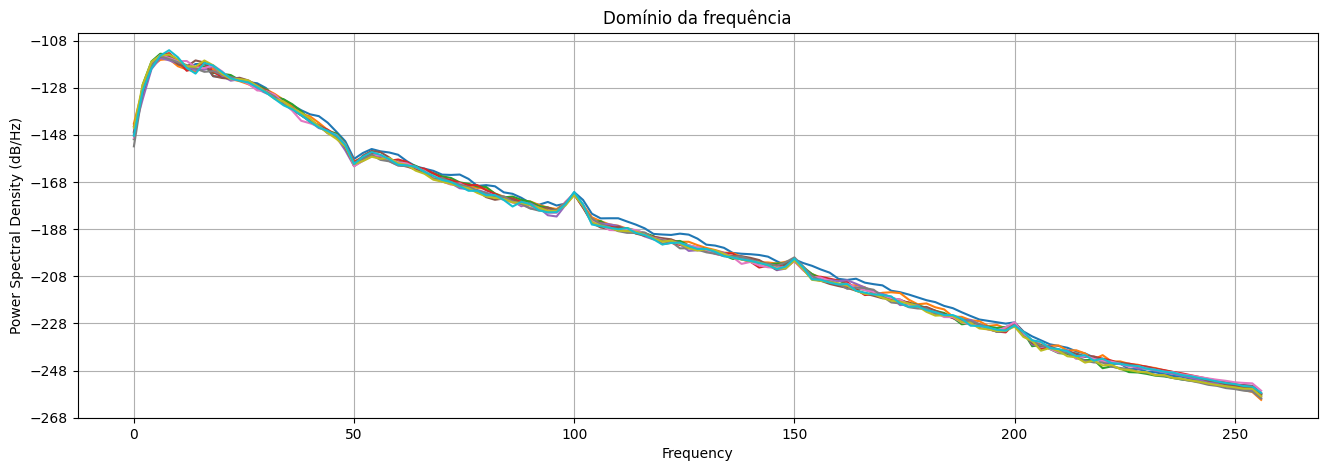

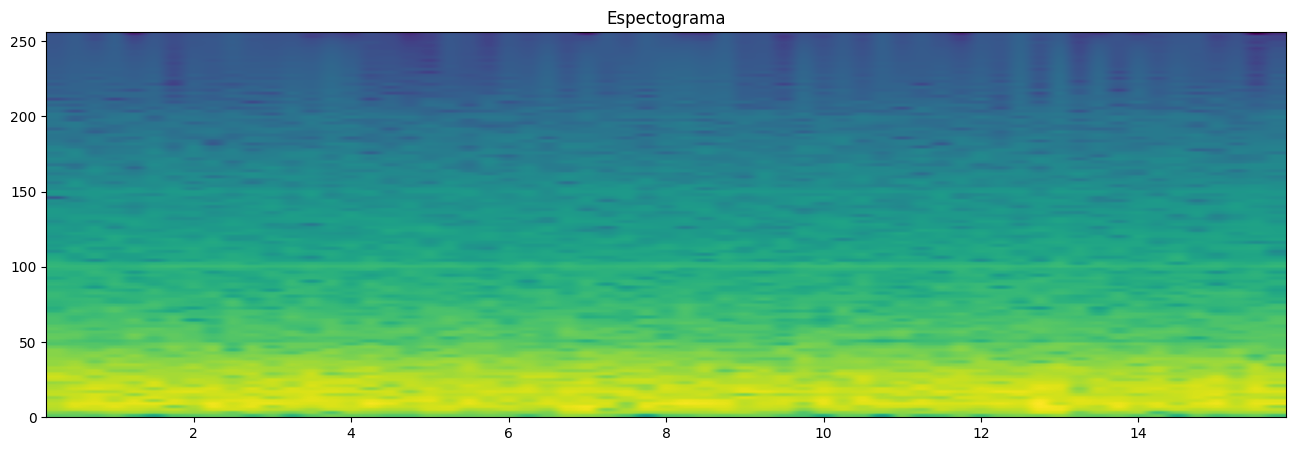

In [4]:
# definição dos tamanhos das figuras
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

In [5]:
#abcissa = frequencias
# criação de um objeto "info"
n_channels = 1 # criação de um canal. no beta vai ter mais
sfreq = 512 #64 beta; 512 amostras serão registradas pors egundo (2x256)
ch_names = ['Oz'] # nome do canal
ch_types = ['eeg'] # tipo do canal
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [6]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../datasets/avi/multi/label_sub6.npy")
print(labels, labels.shape)
#repete os targets 3 vezes

[7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2] (10,)


In [10]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
# adicionando label como "épocas" do sinal
labels = np.load("../datasets/avi/multi/label_sub6.npy")
# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(10, dtype=int),
    le.fit_transform(labels))
)
print(events) # a coluna. do meio cortou nada, a última coluna é identificador do evento
event_dict = {'7.5':0, '8.2':1, '7':2, '6':3} 
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict) # 3 eventos com 10...
mne_data

[[0 0 2]
 [1 0 3]
 [2 0 1]
 [3 0 3]
 [4 0 0]
 [5 0 2]
 [6 0 0]
 [7 0 0]
 [8 0 3]
 [9 0 3]]
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


Number of events,10
Events,6: 47: 27.5: 38.2: 1
Time range,0.000 – 15.998 s
Baseline,off


Need more than one channel to make topography for eeg. Disabling interactivity.



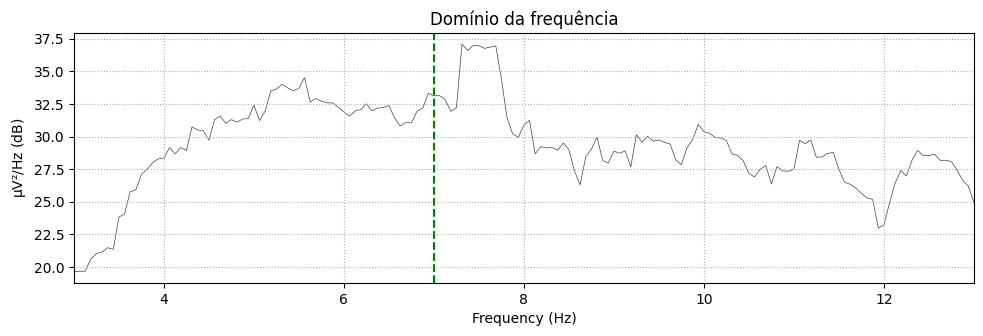

Need more than one channel to make topography for eeg. Disabling interactivity.



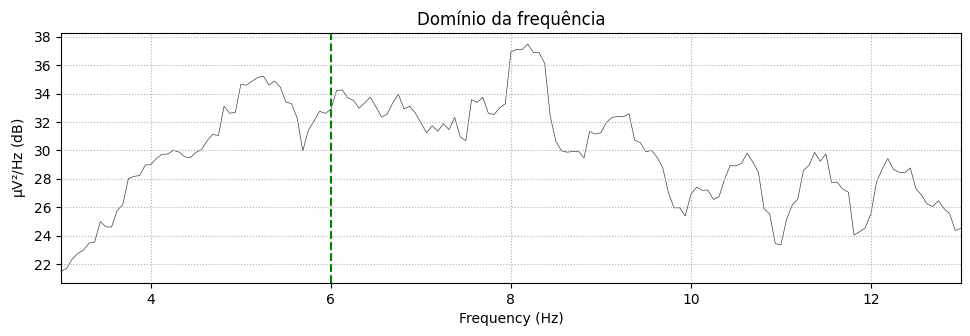

Need more than one channel to make topography for eeg. Disabling interactivity.



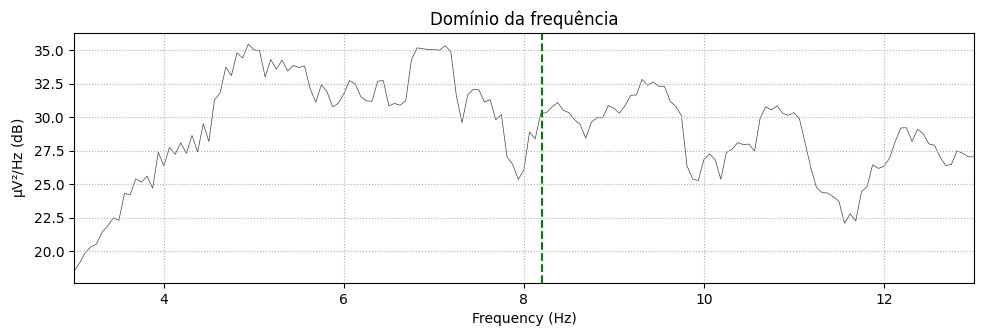

Need more than one channel to make topography for eeg. Disabling interactivity.



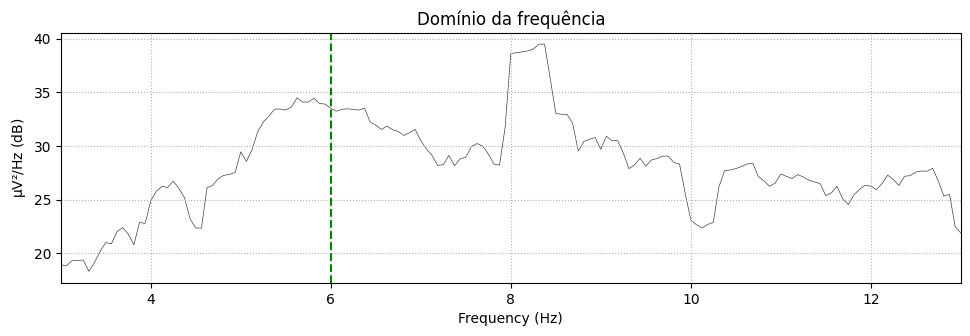

Need more than one channel to make topography for eeg. Disabling interactivity.



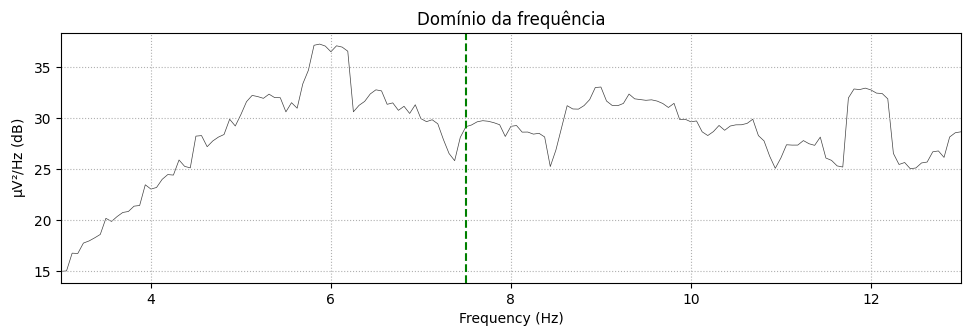

Need more than one channel to make topography for eeg. Disabling interactivity.



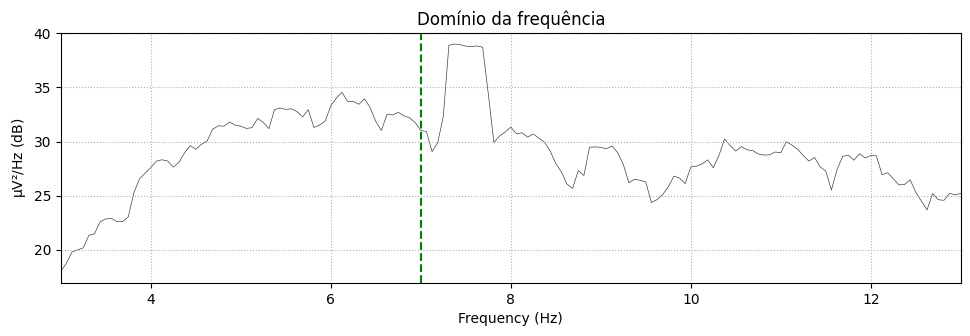

Need more than one channel to make topography for eeg. Disabling interactivity.



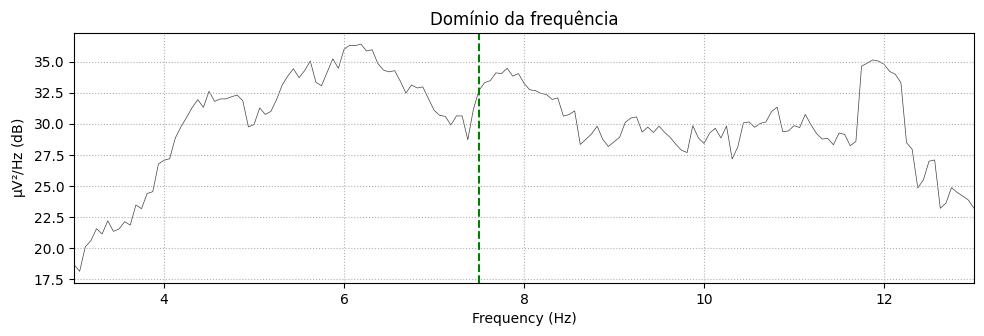

Need more than one channel to make topography for eeg. Disabling interactivity.



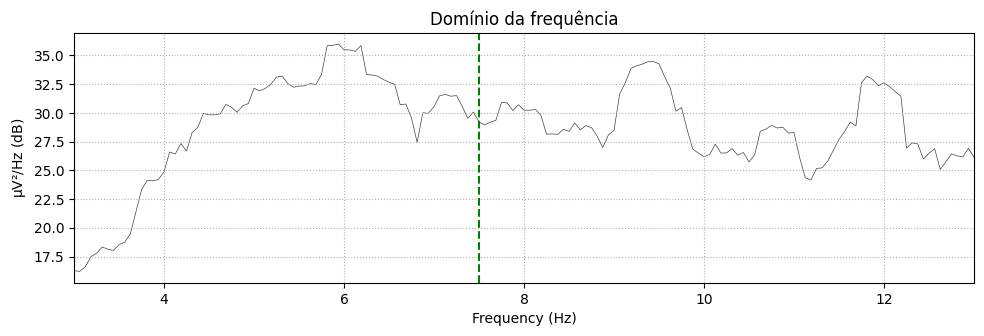

Need more than one channel to make topography for eeg. Disabling interactivity.



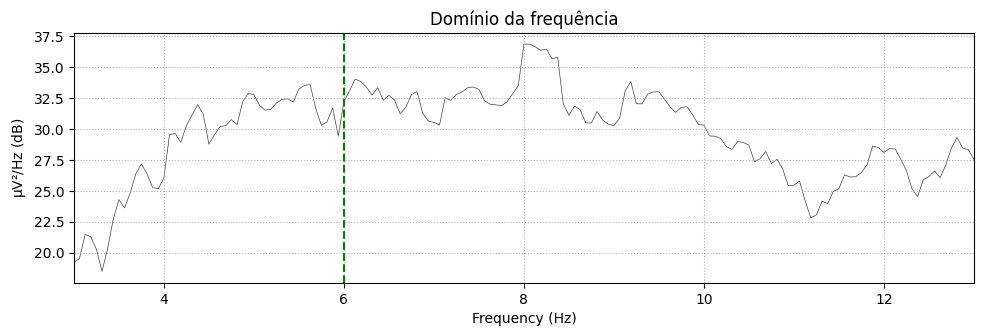

Need more than one channel to make topography for eeg. Disabling interactivity.



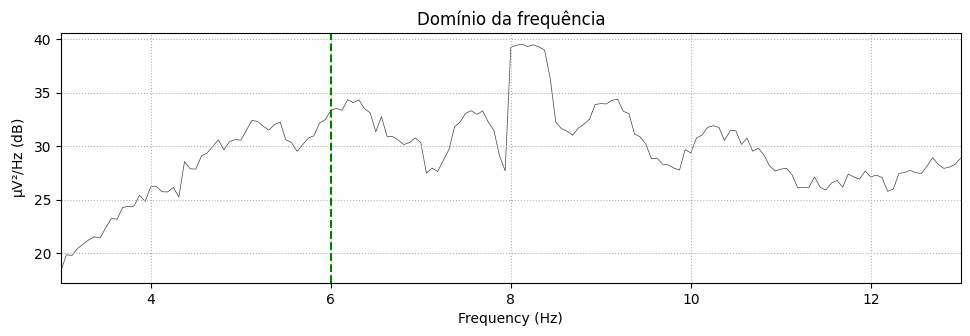

In [11]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False) # ampliação do gráfico no domínio da frequência
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()